In [204]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


device = "cuda" if torch.cuda.is_available() else "cpu"
print('libraries imported')
print("Using {} device".format(device))

libraries imported
Using cuda device


MNIST normalized dataset with one hot labels target vectors will be used again.

In [205]:
def display_mnist_tensor(x):
    n = 28
    plt.imshow(x.numpy().reshape(n, n), cmap="copper") 

train_input, train_target, test_input, test_target = prologue.load_data(one_hot_labels = True, normalize = True, flatten = False)
print(train_input.shape, test_input.shape)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


We start by creating our model through the class **Net** (which inherits from the *nn.Module* class). We define the layers of our neural network through the **__init__()** method. 

Then we define the way which the layers interact with each other through the **forward()** function.

In [197]:
class Net(nn.Module):
    def __init__(self, hidden_layer_n): ## defining the layers
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, hidden_layer_n)
        self.fc2 = nn.Linear(hidden_layer_n, 10)

    def forward(self, x): 
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

We define a function to train our model by exploring the training set using batches. The goal being the minimization of the loss function which can be defined as a parameter too (we are using *MSELoss*). The model's parameters (weights and biases) are updated as ($p -= \eta * \frac{\delta p}{\delta l}$), based on the gradients with respect to these parameters.

Another function to compute the errors between the true classes and predictions is defined.

In [198]:
def train_model(n_epochs, eta, loss_criterion, model, train_input, train_target, mini_batch_size):
    for e in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = loss_criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()

            model.zero_grad() ## setting the gradients to zero before the loss calculation
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
                    
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))
    
    
def compute_nb_errors(model, input, target):
    with torch.no_grad():
        accuracy = 0.0
        max_indeces = torch.unsqueeze(torch.argmax(input, dim = 1), 1) ## getting the indexes of max values
        accuracy = torch.gather(target, 1, max_indeces).sum() ## sum how many 1s did we find (correct classification)
    return 1.0 - (accuracy / target.size(0)).item()

Defining Parameters: the loss function $l$, learning rate (step size) $\eta$, mini batch size $b$, number of epochs $n$.

Regarding batch size $b$, a smaller batch size increases training time however increases accuracy too (e.g a jump $100 \to 10$).

In [199]:
criterion = nn.MSELoss()
eta = 1e-1
mini_batch_size = 10
nb_epochs = 25

## Print the weights
# for param in model.parameters():
#   print(param.data)

Training the model we defined.

In [200]:
model = Net(hidden_layer_n=200)
train_model(nb_epochs, eta, criterion, model, train_input, train_target, mini_batch_size)

Model Training Finished - Final loss after 25 epochs: 0.521716499235481


Evaluating the trained model on the test data.

In [201]:
error_train = compute_nb_errors(model, model(train_input), train_target)
error_test = compute_nb_errors(model, model(test_input), test_target)

print('Classification Error on the training set: {0:.2f}%'.format(error_train * 100))
print('Classification Error on the testing set: {0:.2f}%'.format(error_test * 100))

Classification Error on the training set: 0.20%
Classification Error on the testing set: 5.00%


Visualization of what the model is predicting again.

Predictions example: [2, 8, 8, 8, 8, 7, 4, 7, 3, 0]


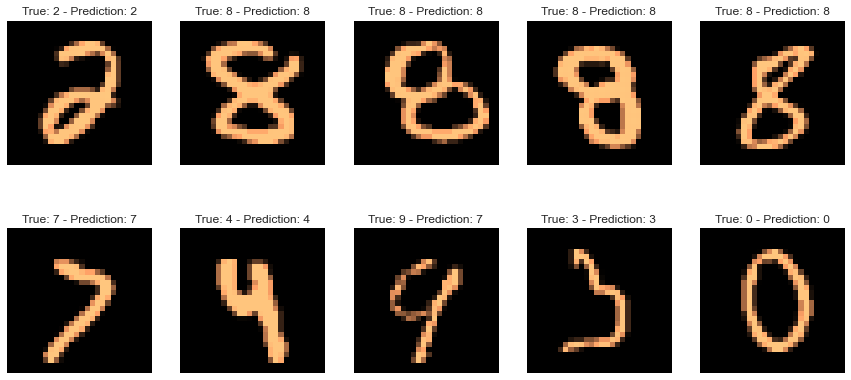

In [202]:
import random

i_random = random.randrange(0, test_input.size(0) - 10)
predictions_batch = [torch.argmax(model(test_input)[i]).item() for i in range(i_random, i_random + 10)]
print('Predictions example:', predictions_batch)

fig1, axes = plt.subplots(2, 5, figsize = (15, 7))
ax = axes.ravel()
for i in range(i_random, i_random + 10):
    ax[i - i_random].set_title('True: {} - Prediction: {}'.format(torch.argmax(test_target[i], dim=0).item(), predictions_batch[i - i_random]))
    ax[i - i_random].imshow(test_input[i].view(28, 28), cmap='copper')
    ax[i - i_random].axis('off')
plt.show()

3. Testing the model out with different numbers of hidden layers.

In [203]:
hidden_layers = [10, 50, 200, 500, 1000]

for layer_n in hidden_layers:   
    model = Net(hidden_layer_n=layer_n)
    train_model(nb_epochs, eta, criterion, model, train_input, train_target, mini_batch_size)
    
    error_train = compute_nb_errors(model, model(train_input), train_target)
    error_test = compute_nb_errors(model, model(test_input), test_target)
    
    print('Classification Error on the training set with {} hidden layers: {}%'.format(layer_n, error_train * 100))
    print('Classification Error on the testing set with {} hidden layers: {}%'.format(layer_n, error_test * 100))
    print('')

Model Training Finished - Final loss after 25 epochs: 3.391419881954789
Classification Error on the training set with 10 hidden layers: 3.8999974727630615%
Classification Error on the testing set with 10 hidden layers: 15.200001001358032%

Model Training Finished - Final loss after 25 epochs: 0.5415978769306093
Classification Error on the training set with 50 hidden layers: 0.1999974250793457%
Classification Error on the testing set with 50 hidden layers: 5.099999904632568%

Model Training Finished - Final loss after 25 epochs: 0.49953892605844885
Classification Error on the training set with 200 hidden layers: 0.1999974250793457%
Classification Error on the testing set with 200 hidden layers: 4.199999570846558%

Model Training Finished - Final loss after 25 epochs: 0.45068314869422466
Classification Error on the training set with 500 hidden layers: 0.09999871253967285%
Classification Error on the testing set with 500 hidden layers: 5.099999904632568%

Model Training Finished - Final l